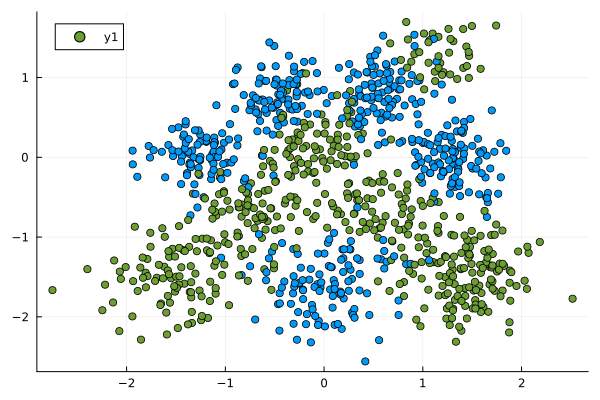

In [1]:
using DataFrames, CSV, DelimitedFiles
using Plots
using Zygote
using ForwardDiff

X = [ones(1000, 1) readdlm("X.txt", ' ', Float64)] 
y = readdlm("y.txt", ' ', Int64) 

scatter(X[:, 2], X[:, 3], markercolor=y)

## Regression

Model using:

$$ y = w^T X + b + \epsilon_n$$

where:

$$ \epsilon_n \sim \mathcal{N}(0, \sigma^2) $$

by adding a third dimension to X, as done above, we can use:

$$ y = w^T \tilde{X} + \epsilon_n$$

Ultimately we have:

$$ p(y_n | \tilde{\mathbf{x}}_n, \mathbf{\theta}) = \mathcal{N}(y_n | \mathbf{w}^t \tilde{\mathbf{x}}_n, \sigma^2) $$



## Logistic Regression

$$\begin{align*}
 p(y_n | \tilde{\mathbf{x}}_n, \mathbf{\theta}) &= y_n \sigma (\mathbf{w}^T \tilde{\mathbf{x}}_n) + (1 - y_n) (1 - \sigma (\mathbf{w}^T \tilde{\mathbf{x}}_n))\\
&= y_n \sigma (\mathbf{w}^T \tilde{\mathbf{x}}_n) + (1 - y_n)  \sigma (-\mathbf{w}^T \tilde{\mathbf{x}}_n)\\
\end{align*}$$


In [2]:
logistic(X) = 1 / (1 + exp(-clamp.(X, -1000, 1000)))

likelihood(X, y, w) = y .* logistic.(X * w) .+ (1 .- y) .* logistic.(-X * w)

log_loss(X, y, w) = sum(log.(likelihood(X, y, w))) / size(X, 1)

log_loss (generic function with 1 method)

-0.9198356740291268


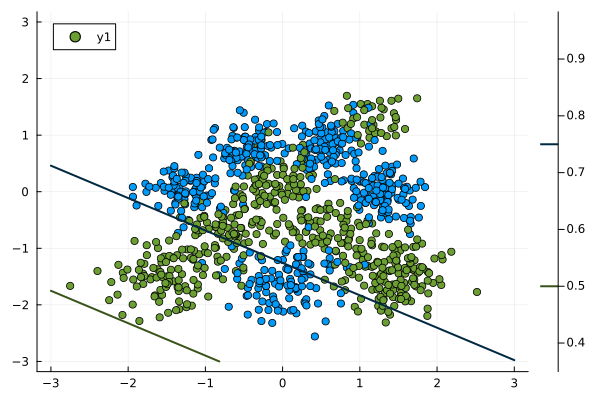

In [3]:
w = randn(3, 1)
predictions = logistic.(X * w)

println(log_loss(X, y, w))
scatter(X[:, 2], X[:, 3], markercolor=y)
contour!(-3:0.01:3, -3:0.01:3, 
        (x, y) -> logistic.([1 x y] * w)[1], 
        levels=[0.25,0.5,0.75], c=[0,:black,1], lw=2)


In [4]:
# Gradient ascent
function train(Input, labels; lr=0.001, epochs=1_000)
    n_features = size(Input, 2)
    params = randn(n_features, 1) .* 0.1 / (10 * n_features) # Initialize weights
    println("Initial log likelihood = $(log_loss(Input, labels, params))")
    
    for i in 1:epochs
        lr = lr * 0.9999  # Decrease learning rate
        # Compute gradient using Zygote
        grad = Zygote.gradient(params -> log_loss(Input, labels, params), params)[1]

        # Update weights (ascent because we're maximizing)
        params .+= lr * grad

        # Print progress every 100 epochs
        if i % 100 == 0
            loss = log_loss(Input, labels, params)
            println("Epoch $i: log likelihood = $loss")
            
            
        end
    end
    println("Training complete.")
    println("Final log likelihood = $(log_loss(Input, labels, params))")
    return params
end

train (generic function with 1 method)

Initial log likelihood = -0.6942169221122976
Epoch 100: log likelihood = -0.6909993430106981
Epoch 200: log likelihood = -0.6879904319973872
Epoch 300: log likelihood = -0.6851737923160053
Epoch 400: log likelihood = -0.6825344503812708
Epoch 500: log likelihood = -0.6800587308603478
Epoch 600: log likelihood = -0.6777341412707281
Epoch 700: log likelihood = -0.6755492658239083
Epoch 800: log likelihood = -0.673493668117918
Epoch 900: log likelihood = -0.6715578021998563
Epoch 1000: log likelihood = -0.6697329314717515
Training complete.
Final log likelihood = -0.6697329314717515


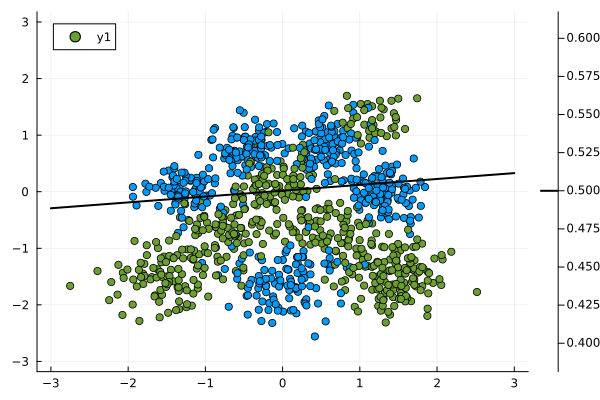

In [5]:
w_opt = train(X, y)
pred = logistic.(X * w_opt)

scatter(X[:, 2], X[:, 3], markercolor=y)
contour!(-3:0.01:3, -3:0.01:3, 
        (x, y) -> logistic.([1 x y] * w_opt)[1], 
        levels=[0.25,0.5,0.75], c=[0,:black,1], lw=2)


Initial log likelihood = -0.6930703920550546
Epoch 100: log likelihood = -0.6830952656441126
Epoch 200: log likelihood = -0.6771705116077096
Epoch 300: log likelihood = -0.6733766141184431
Epoch 400: log likelihood = -0.6707340742284716
Epoch 500: log likelihood = -0.6687349079305254
Epoch 600: log likelihood = -0.6671086749477522
Epoch 700: log likelihood = -0.6657074461123259
Epoch 800: log likelihood = -0.6644482407752353
Epoch 900: log likelihood = -0.6632834247142126
Epoch 1000: log likelihood = -0.6621850523126142
Training complete.
Final log likelihood = -0.6621850523126142


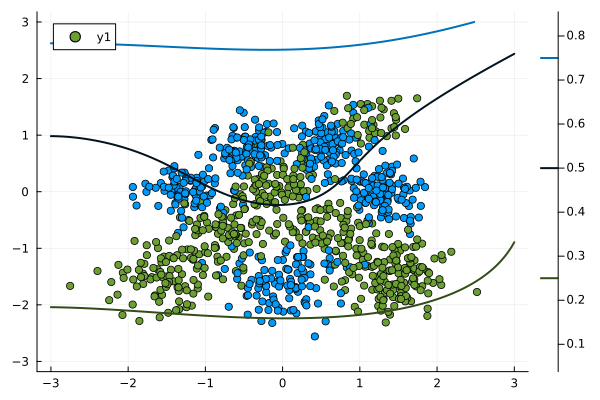

In [6]:
X_nl2 = [X X[:, 2].^2 X[:, 3].^2 X[:, 2].*X[:, 3]]
X_nl3 = [X_nl2 X[:, 2].^3 X[:, 3].^3]

w_opt_nl = train(X_nl3, y)
predictions = logistic.(X_nl3 * w_opt_nl)

scatter(X[:, 2], X[:, 3], markercolor=y)
contour!(-3:0.01:3, -3:0.01:3, 
         (x, y) -> logistic.([1 x y x*x y*y x*y x*x*x y*y*y] * w_opt_nl)[1], 
         levels=[0.25,0.5,0.75], c=[0,:black,1], lw=2)

## Basis Functions

Expanding on the above result, we look at other basis functions that better capture non-linearities further from the origin


In [7]:
function evaluate_gaussian_basis_functions(l, X, Z)
    X2 = sum(X.^2, dims=2)
    Z2 = sum(Z.^2, dims=2)
    ones_Z = ones(size(Z, 1))
    ones_X = ones(size(X, 1))
    r2 = X2 * ones_Z' .- 2 * (X * Z') .+ ones_X * Z2'
    return exp.(-0.5 / l^2 .* r2)
end

evaluate_gaussian_basis_functions (generic function with 1 method)

Initial log likelihood = -0.693149106049069
Epoch 100: log likelihood = -0.6757779046103727
Epoch 200: log likelihood = -0.6595543708679885
Epoch 300: log likelihood = -0.6443845349721717
Epoch 400: log likelihood = -0.6301821532242062
Epoch 500: log likelihood = -0.6168683238904072
Epoch 600: log likelihood = -0.6043710344699837
Epoch 700: log likelihood = -0.5926246732109391
Epoch 800: log likelihood = -0.5815695292916352
Epoch 900: log likelihood = -0.5711512991354764
Epoch 1000: log likelihood = -0.5613206107749343
Training complete.
Final log likelihood = -0.5613206107749343


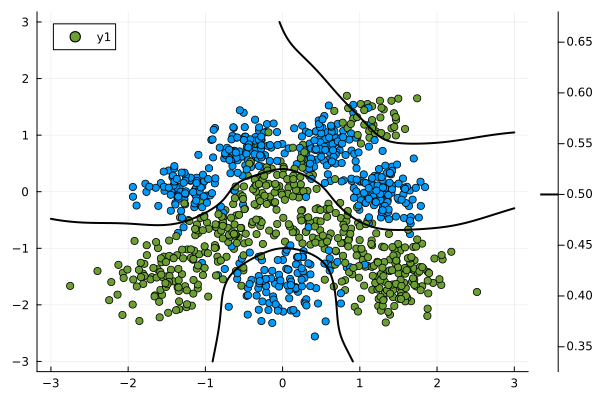

In [14]:
X_basis = evaluate_gaussian_basis_functions(0.25, X, X)
w_opt_basis = train(X_basis, y)
predictions = logistic.(X_basis * w_opt_basis)

scatter(X[:, 2], X[:, 3], markercolor=y)

x_range = range(-3, 3, length=500)
y_range = range(-3, 3, length=500)
points = hcat(repeat(x_range, inner=length(y_range)), repeat(y_range, outer=length(x_range)))
points_basis = evaluate_gaussian_basis_functions(0.25, [ones(500^2) points], X)
points_predictions = logistic.(points_basis * w_opt_basis)
points_predictions_mesh = reshape(points_predictions, 500, 500)
contour!(x_range, y_range, points_predictions_mesh, levels=[0.25,0.5,0.75], c=[0,:black,1], lw=2)